In [0]:
# Adapted from https://github.com/gsurma/style_transfer

In [0]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import models
from scipy.optimize import fmin_l_bfgs_b
from io import BytesIO
from tqdm import trange
from PIL import Image
from tensorflow.keras.backend import function, variable, concatenate, placeholder, gradients, pow, transpose, permute_dimensions, square, dot, sum, batch_flatten
from tensorflow.keras.applications.vgg16 import VGG16

# google collab specific
import errno    
from google.colab import files
import os 
import time
import imageio

In [0]:
# Set paths of images 
image1_path = 'img1.jpg'  # The input image
image2_path = 'img2.jpg'  # The style image
combined_image_path = 'combine.png'

# Define image attributes
image_width = 250
image_height = 250
channels = 3

# Define Imagenet means
imagenet_mean_rgb = [123.68, 116.779, 103.939]

# Define training hyperparameters
content_weight = 0.02
style_weight = 4.5
total_variation_loss_weight = 1.25
epochs = 100

In [0]:
# Load and open the first input image 
im1 = Image.open(image1_path)
im2 = Image.open(image2_path)

In [0]:
# Resize both the images to the sizes defined above
im1 = im1.resize((image_width, image_height))
im2 = im2.resize((image_width, image_height))

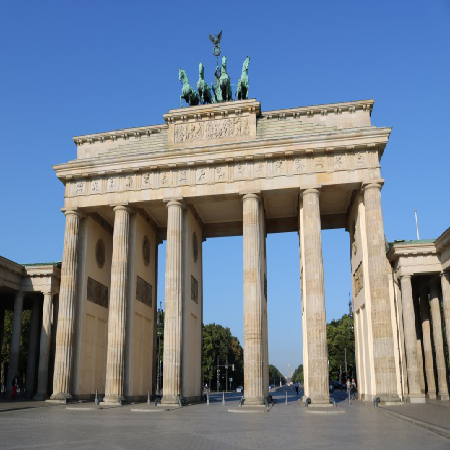

In [0]:
im1

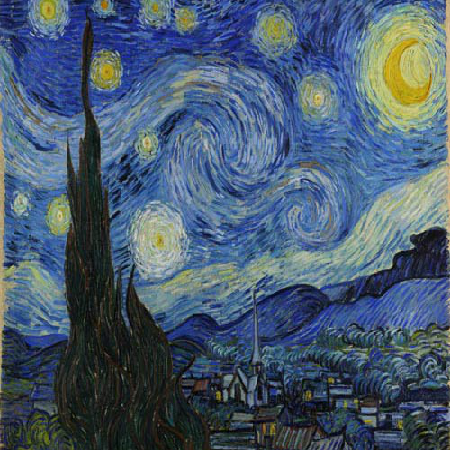

In [0]:
im2

In [0]:
# Normalize the images by subtracting from them the imagenet means
image1_arr = np.expand_dims(np.asarray(im1, dtype='float32'), axis=0)
image1_arr[:, :, :, 0] = image1_arr[:, :, :, 0] - imagenet_mean_rgb[2]
image1_arr[:, :, :, 1] = image1_arr[:, :, :, 1] - imagenet_mean_rgb[1]
image1_arr[:, :, :, 2] = image1_arr[:, :, :, 2] - imagenet_mean_rgb[0]

image2_arr = np.expand_dims(np.asarray(im2, dtype='float32'), axis=0)
image2_arr[:, :, :, 0] = image2_arr[:, :, :, 0] - imagenet_mean_rgb[2]
image2_arr[:, :, :, 1] = image2_arr[:, :, :, 1] - imagenet_mean_rgb[1]
image2_arr[:, :, :, 2] = image2_arr[:, :, :, 2] - imagenet_mean_rgb[0]

In [0]:
# Convert RGB format to BGR
image1_arr = image1_arr[:, :, :, ::-1]
image2_arr = image2_arr[:, :, :, ::-1]

In [0]:
# Create variables and placeholders
image1 = variable(image1_arr)
image2 = variable(image2_arr)
result_image = placeholder((1, image_height, image_width, 3))

In [0]:
# Create model and the tensor input
input_tensor = concatenate([image1, image2, result_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

In [0]:
# Gram matrix
def gram_matrix(inp):
    features = batch_flatten(permute_dimensions(inp, (2, 0, 1)))
    gram = dot(features, transpose(features))
    return gram

# Content loss
def content_loss(content, combined):
    return sum(square(combined - content))

# Style loss 
def style_loss(style, combined):
    style = gram_matrix(style)
    combined = gram_matrix(combined)
    return sum(square(style - combined)) / (4. * (channels ** 2) * ((image_height * image_width) ** 2))  

# Total variation loss
def total_variation_loss(inp):
    term1 = square(inp[:, :image_height-1, :image_width-1, :] - inp[:, 1:, :image_width-1, :])   
    term2 = square(inp[:, :image_height-1, :image_width-1, :] - inp[:, :image_height-1, 1:, :])   
    return sum(pow(term1 + term2, total_variation_loss_weight))


In [0]:
network_layers = dict([(layer.name, layer.output) for layer in model.layers])
network_layers.keys()

dict_keys(['input_5', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool'])

In [0]:
content_layer = 'block2_conv2'
content_layer_features = network_layers[content_layer]
content_layer_features

# Identify content and combined images 
content_image_features = content_layer_features[0, :, :, :]
combined_image_features = content_layer_features[2, :, :, :]

style_layers = ['block1_conv2', 
                'block2_conv2', 
                'block3_conv3', 
                'block4_conv3', 
                'block5_conv3']

In [0]:
# Initialise loss
loss = variable(0)
loss = loss + content_weight * content_loss(content=content_image_features, 
                                            combined=combined_image_features)

In [0]:

for l in style_layers:
    layer_features = network_layers[l]
    style_features = layer_features[1, :, :, :]
    combined_features = layer_features[2, :, :, :]
    styleloss = style_loss(style_features, combined_features)
    loss = loss + (style_weight/ len(style_layers)) * styleloss

loss = loss + total_variation_loss_weight * total_variation_loss(result_image)

# To avoid error while calculating gradients which is not supported in eager mode
tf.compat.v1.disable_eager_execution()

outputs = [loss]
outputs = outputs + gradients(loss, result_image)


# Rerun this cell if error appears

In [0]:
def evaluate_loss_gradient(inp):
    inp = inp.reshape((1, image_height, image_width, channels))
    outs = function([result_image], outputs)([inp])
    loss = outs[0]
    grads = outs[1].flatten().astype('float64')
    return loss, grads    

In [0]:
class Evaluator:
    def loss(self, inp):
        loss, grads = evaluate_loss_gradient(inp)
        self._grads = grads
        return loss
    
    def grads(self, inp):
        return self._grads
    
eval = Evaluator()

In [0]:

def plot_together(im1, im2, im3, filename, epoch):
    all_three_images = Image.new("RGB", (image_width*3, image_height))
    
    all_three_images.paste(im1, box=(0, 0))
    all_three_images.paste(im2, box=(image_width, 0))
    all_three_images.paste(im3, box=(image_width*2, 0))
    if epoch == 14:
        all_three_images.save(filename)


def reproduce_image(x):
    x = x.reshape((image_height, image_width, channels))

    # back to rgb format
    x = x[:, :, ::-1]

    # de-normalize
    x[:, :, 0] += imagenet_mean_rgb[2]
    x[:, :, 1] += imagenet_mean_rgb[1]
    x[:, :, 2] += imagenet_mean_rgb[0]

    x = np.clip(x, 0, 255).astype('uint8')
    output_image = Image.fromarray(x)
    
    return output_image

In [0]:
# Create a random image
x = np.random.uniform(low=0, high=255, size=(1, image_height, image_width, channels)) - 128 
# x = np.expand_dims(np.asarray(im1, dtype='float32'), axis=0) - 128

In [0]:

try:
    os.mkdir('images')
except OSError as exc:
    if exc.errno == errno.EEXIST and os.path.isdir('images'):
        pass
    else:
        raise
            
train_loss = []

# Start training
for i in trange(epochs):
    x, loss, info = fmin_l_bfgs_b(eval.loss, 
                                  x.flatten(),
                                  fprime=eval.grads,
                                  maxfun=20)
    train_loss.append(loss)
    print("Epoch {} | Loss {}".format(i, loss))


    im3 = reproduce_image(x)
    filename = 'images/' + str(i) + '.png'
    plot_together(im1, im2, im3, filename, i)
    
# file is not finished being written by the time google attempts to "fetch" the file
#    time.sleep(10)  
 #   try:
  #      files.download(filename)
   # except:
    #    pass


  7%|▋         | 1/15 [00:23<05:25, 23.25s/it]

Epoch 0 | Loss 17522569216.0



 13%|█▎        | 2/15 [00:46<05:00, 23.14s/it]

Epoch 1 | Loss 24834404352.0



 20%|██        | 3/15 [01:09<04:37, 23.12s/it]

Epoch 2 | Loss 28233562112.0



 27%|██▋       | 4/15 [01:32<04:14, 23.09s/it]

Epoch 3 | Loss 28882587648.0



 33%|███▎      | 5/15 [01:55<03:50, 23.08s/it]

Epoch 4 | Loss 26257692672.0



 40%|████      | 6/15 [02:18<03:27, 23.09s/it]

Epoch 5 | Loss 28103577600.0



 47%|████▋     | 7/15 [02:41<03:04, 23.03s/it]

Epoch 6 | Loss 27617271808.0



 53%|█████▎    | 8/15 [03:04<02:41, 23.02s/it]

Epoch 7 | Loss 26045198336.0



 60%|██████    | 9/15 [03:28<02:19, 23.31s/it]

Epoch 8 | Loss 26239643648.0



 67%|██████▋   | 10/15 [03:51<01:56, 23.21s/it]

Epoch 9 | Loss 28942649344.0



 73%|███████▎  | 11/15 [04:14<01:32, 23.08s/it]

Epoch 10 | Loss 25483925504.0



 80%|████████  | 12/15 [04:36<01:09, 23.01s/it]

Epoch 11 | Loss 29750372352.0



 87%|████████▋ | 13/15 [04:59<00:45, 22.95s/it]

Epoch 12 | Loss 28893110272.0



 93%|█████████▎| 14/15 [05:22<00:22, 22.96s/it]

Epoch 13 | Loss 27717310464.0



100%|██████████| 15/15 [05:45<00:00, 22.96s/it]


Epoch 14 | Loss 25496578048.0


In [0]:

file = os.listdir('images')
file.sort()

with imageio.get_writer('style_transfer.gif', mode='I', duration=0.2) as writer:
    for filename in file:
        image = imageio.imread('images/' + filename)
        writer.append_data(image)

# files.download('images/style_transfer.gif')